In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Analyte History - Calculate and Plot Outlier Metrics
--
**Metrics**

1. An outlier value: the mean percentile offset of the sample from the background data
2. A quartile value: the percentage of the sample outside the quartiles of the background data
3. A 5% value: the percentage of the sample outside 5 and 95% of the background data



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
def outlierval(data, sample):
    """mean percentile offset of sample from data"""
    perc = np.array([])
    for column in data:
        p = stats.percentileofscore(data[column], sample[column].iloc[0])
        perc = np.append(perc, p)
    perc = abs(perc - 50)*2
    perc = np.mean(perc)
    return perc

In [4]:
def quartval(data, sample):
    """percentage of columns outside 25-75%"""
    quart = 0
    for column in data:
        lq = data[column].quantile(q=0.25)
        uq = data[column].quantile(q=0.75)
        if (sample.iloc[0][column] > uq) or (sample.iloc[0][column] < lq):
            quart += 1
    quart = (float(quart) / float(len(data.columns))) * 100
    return quart

In [5]:
def fiveval(data, sample):
    """percentage of columns outside 5-95%"""
    five = 0
    for column in data:
        lf = data[column].quantile(q=0.05)
        uf = data[column].quantile(q=0.95)
        if (sample.iloc[0][column] > uf) or (sample.iloc[0][column] < lf):
            five += 1
    five = (float(five) / float(len(data.columns))) * 100
    return five

**Set basic parameters**

In [6]:
siteID = 'TO051'
years = '20'
days = str(int(years)*365)
minobs = 5 #minimum number of observations to calculate what is typical
types = ['Al-w', 'As-w', 'B-w', 'Br-w', 'Ca-w', 'Cs-w', 'Cl-w', 'F-w', 'Fe-w', 'HCO3-w', 'H2S-w', 'K-w', 'Li-w', 'Mg-w', 'Na-w', 'NH3-w', 'NO3-N-w', 'PO4-P-w', 'Rb-w', 'SO4-w', 'SiO2-w']

**Get all data**

In [7]:
#setup dataframes
names = ['date', 'obs']
dfall = pd.DataFrame() #for background
dflast = pd.DataFrame() #for last values

#loop through typeIDs
for typeID in types:
    url = 'https://fits.geonet.org.nz/observation?siteID='+siteID+'&typeID='+typeID+'&days='+days
    df = pd.read_csv(url, skiprows=1, parse_dates=True, names=names, usecols=[0,1], index_col=0)
    df['typeID'] = typeID
    dfall = dfall.append(df)

**Prepare data**

In [8]:
dtab = dfall.pivot(columns='typeID', values='obs')
dtab.replace(to_replace=0, value=np.nan, inplace=True)

**Calculate data metrics**

In [9]:
#empty dataframe for metrics
dfov = pd.DataFrame()
dfqv = pd.DataFrame()
dffv = pd.DataFrame()

#loop through dataframe
for rows in range(minobs+1,len(dtab)+1):
    data = dtab.iloc[0:rows]
    
    #drop columns with null final value
    droplist = [col for col in data.columns if pd.isnull(data[col].iloc[-1])]
    data.drop(droplist, axis='columns', inplace=True)
        
    #drop columns with insufficient non-null values
    droplist = [col for col in data.columns if pd.notnull(data[col]).sum() < minobs+1]
    data.drop(droplist, axis='columns', inplace=True)
    
    finaldate = data.index[-1].strftime('%Y-%m-%d')
    #print 'rows='+str(rows), 'date= '+finaldate
    #get last values
    dlast = data.iloc[-1:]
    #drop last value from from data
    data.drop(data.index[-1:], inplace=True)

    #calculate metrics, provided valid background data
    if len(data.columns) > 0:  
        #metric #1
        ov = outlierval(data, dlast)
        idx = pd.to_datetime(dlast.index[0])
        dfov = dfov.append({'date':idx, 'val':ov}, ignore_index=True)

        #metric #2
        qv = quartval(data, dlast)
        idx = pd.to_datetime(dlast.index[0])
        dfqv = dfqv.append({'date':idx, 'val':qv}, ignore_index=True)

        #metric #3
        fv = fiveval(data, dlast)
        idx = pd.to_datetime(dlast.index[0])
        dffv = dffv.append({'date':idx, 'val':fv}, ignore_index=True)

#set date as index in metrics dataframes
dfov.set_index('date', inplace=True)
dfqv.set_index('date', inplace=True)
dffv.set_index('date', inplace=True)

**Plot metric #1**

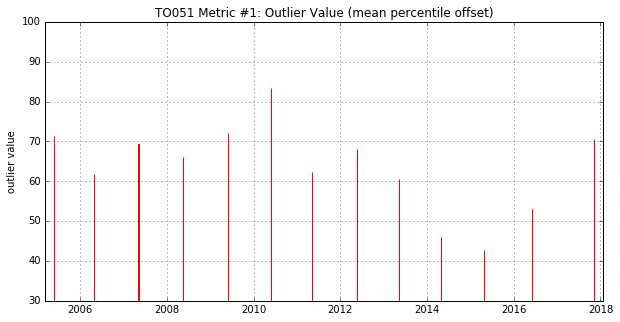

In [10]:
fig, met1 = plt.subplots(figsize=(10,5))
met1.bar(dfov.index, dfov.val, width=1, color='red', edgecolor='red', align='center')
met1.set_ylabel('outlier value')
met1.set_title(siteID+' Metric #1: Outlier Value (mean percentile offset)')

#extend x axes so all points are clear
xmin, xmax = met1.get_xlim()
xmin *= 0.9999
xmax *= 1.0001
met1.set_xlim(xmin, xmax)

met1.set_ylim(30, 100)
met1.grid()

plotname = siteID+'_metric-1.png'
fig = met1.get_figure()
fig.savefig(plotname, dpi=200)

**Plot metric #2**

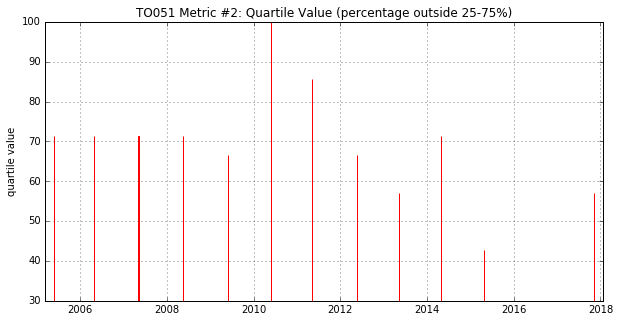

In [11]:
fig, met2 = plt.subplots(figsize=(10,5))
met2.bar(dfqv.index, dfqv.val, width=1, color='red', edgecolor='red', align='center')
met2.set_ylabel('quartile value')
met2.set_title(siteID+' Metric #2: Quartile Value (percentage outside 25-75%)')

#extend x axes so all points are clear
xmin, xmax = met2.get_xlim()
xmin *= 0.9999
xmax *= 1.0001
met2.set_xlim(xmin, xmax)

met2.set_ylim(30, 100)
met2.grid()

plotname = siteID+'_metric-2.png'
fig = met2.get_figure()
fig.savefig(plotname, dpi=200)

**Plot metric #3**

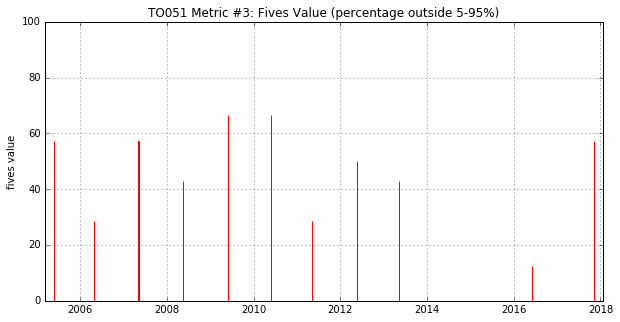

In [12]:
fig, met3 = plt.subplots(figsize=(10,5))
met3.bar(dffv.index, dffv.val, width=1, color='red', edgecolor='red', align='center')
met3.set_ylabel('fives value')
met3.set_title(siteID+' Metric #3: Fives Value (percentage outside 5-95%)')

#extend x axes so all points are clear
xmin, xmax = met3.get_xlim()
xmin *= 0.9999
xmax *= 1.0001
met3.set_xlim(xmin, xmax)

met3.set_ylim(0, 100)
met3.grid()

plotname = siteID+'_metric-3.png'
fig = met3.get_figure()
fig.savefig(plotname, dpi=200)